# Aging Contact Surface

Predicting age of contact from contact interface gray-scale images.

In [2]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import numpy as np
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
import re

In [22]:
csv_dir = 'D:/MLdata/18-01-09d-Exp/Jedi Data/'

#Get all folder names
image_folders = [filename for filename in os.listdir(csv_dir+'sub_images/')]

all_data = []
labels = []
times = []
normals = []
shears = []
indices = []

for folder in image_folders[:3]:
    # Get 3D matrix of data
    data = []
    label = []
    for filename in os.listdir(csv_dir+'sub_images/'+folder+'/'):
        if 'image' in filename:
            #Read in data
            data.append(np.loadtxt(csv_dir+'sub_images/'+folder+'/'+filename, delimiter=','))
            #Obtain the image number
            result = re.search('image_(.*)_x', filename)
            label.append(float(result.group(1))) 
    all_data.append(data) # collect datas
    labels.append(label)
    stats = np.loadtxt(csv_dir+'sub_images/'+folder+'/labels_' + folder +'.csv', delimiter=',')
    # Append stats
    indices.append(stats[:,0])
    times.append(stats[:,1])
    shears.append(stats[:,2])
    normals.append(stats[:,3])

In [23]:
# Obtain target labels
time_labels = []
normal_labels = []
shear_labels = []
for i, label in enumerate(labels):
    time_label = []
    normal_label = []
    shear_label = []
    for lab in label:
        j = np.where(indices[i] == lab)
        time_label.append(times[i][j][0])
        normal_label.append(normals[i][j][0])
        shear_label.append(shears[i][j][0])
    time_labels.append(time_label)
    normal_labels.append(normal_label)
    shear_labels.append(shear_label)

In [24]:
# Assemble targets, shuffle data, and assign training and testing sets

for idx, data in enumerate(all_data):
    # Get data in right shape
    targets = np.vstack((time_labels[idx],normal_labels[idx],shear_labels[idx])).T
    data = np.dstack(data).T

    # Shuffle data and labels
    s = np.arange(data.shape[0])
    np.random.shuffle(s)
    threeD_data = data[s,:,:]
    targets = targets[s,:]

    # Split train and test
    train_size = round(0.8*data.shape[0])
    train_data = data[:train_size,:,:]
    test_data = data[train_size:,:,:]
    train_labels = targets[:train_size,:]
    test_labels = targets[train_size:,:]

In [25]:
def build_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(100,100)),
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(100,100)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(3)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return (model)


def build_cnn():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(16, kernel_size=(8, 8), strides=(1, 1),
                     activation='tanh',
                     input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Conv2D(32, (8, 8), activation='tanh'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(3), activation='relu'))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return (model)

In [26]:
#model = build_model()
model = build_cnn()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [27]:
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

model.fit(train_data, train_labels, epochs=20)
predictions=model.predict(test_data)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
7740/7740 [==============================] - 118s 15ms/sample - loss: 6438.1053 - mean_absolute_error: 43.6219 - mean_squared_error: 6438.1050
Epoch 2/20
7740/7740 [==============================] - 117s 15ms/sample - loss: 5404.8570 - mean_absolute_error: 37.4922 - mean_squared_error: 5404.8555
Epoch 3/20
7740/7740 [==============================] - 117s 15ms/sample - loss: 5288.7376 - mean_absolute_error: 36.6020 - mean_squared_error: 5288.7363
Epoch 4/20
7740/7740 [==============================] - 117s 15ms/sample - loss: 5246.8344 - mean_absolute_error: 36.1170 - mean_squared_error: 5246.8359
Epoch 5/20
7740/7740 [==============================] - 118s 15ms/sample - loss: 5224.3589 - mean_absolute_error: 35.6696 - mean_squared_error: 5224.3564
Epoch 6/20
7740/7740 [==============================] - 118s 15ms/sample - loss: 5199.4062 - mean_absolute_error: 35.3840 - mean_squared_error: 5199.4053
Epoch 7/20
7740/7740 [======

R = 0.4789063752038242


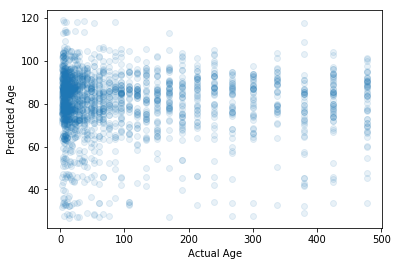

R = 0.4976402671006246


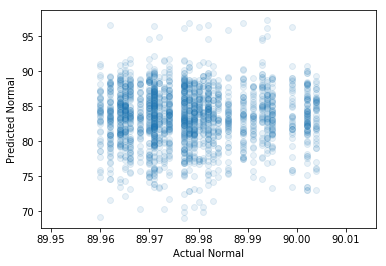

R = 0.11743104475078112


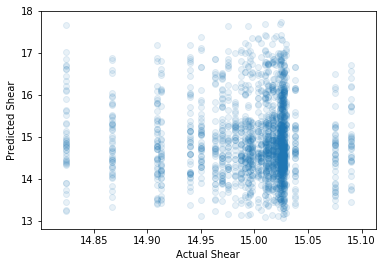

In [28]:
# Score and visualize predictions
from scipy.stats import pearsonr

actual_times = test_labels[:,0]
predicted_times = predictions[:,0]

actual_normal = test_labels[:,1]
predicted_normal = predictions[:,1]

actual_shear = test_labels[:,2]
predicted_shear = predictions[:,2]

print('R = '+str(pearsonr(actual_times, predicted_times)[1]))

plt.figure()
plt.scatter(actual_times,predicted_times, alpha=0.1)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

print('R = '+str(pearsonr(actual_normal, predicted_normal)[1]))

plt.figure()
plt.scatter(actual_normal,predicted_normal, alpha=0.1)
plt.xlabel('Actual Normal')
plt.ylabel('Predicted Normal')
plt.show()

print('R = '+str(pearsonr(actual_shear, predicted_shear)[1]))

plt.figure()
plt.scatter(actual_shear,predicted_shear, alpha=0.1)
plt.xlabel('Actual Shear')
plt.ylabel('Predicted Shear')
plt.show()